# Spam recognition

## Mark a file as spam or not-spam based on a given set of keywords

In [6]:
# Since the data is unstructured, we need to
# 1. Clean the dataste
# 2. Remove stop words
# 3. Lemmatize (group similar words from the dataset)
# 4. Numeric representation of text data before passing into the model

# Import libraries

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aishi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aishi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aishi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aishi\AppData\Roaming\nltk_data...


In [7]:
# Check the data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Print the dataset
spam_data = pd.read_csv("data/Spam-Classification.csv")
print(spam_data.head())

# Create the feature and target variables
spam_classes_raw = spam_data["CLASS"]       # "CLASS" column contains the feature variable
spam_messages = spam_data["SMS"]            # "SMS" column contains the target variables: spam and ham (not spam)

  CLASS                                                SMS
0   ham   said kiss, kiss, i can't do the sound effects...
1   ham      &lt;#&gt; ISH MINUTES WAS 5 MINUTES AGO. WTF.
2  spam  (Bank of Granite issues Strong-Buy) EXPLOSIVE ...
3  spam  * FREE* POLYPHONIC RINGTONE Text SUPER to 8713...
4  spam  **FREE MESSAGE**Thanks for using the Auction S...


Remove stop words and sort the keywords in a lemmatized array

In [8]:
import nltk
import tensorflow as tf

from sklearn.feature_extraction.text import TfidfVectorizer

# Use custom tokenizer to remove stop words and lemmatize the data
def customTokenizer(keyword):
    tokens=nltk.word_tokenize(keyword)      #Split string as tokens
    clear_stopwords = list(filter(lambda token: token not in stopwords.words('english'), tokens))        # Filter for stopwords

    #Perform lemmatization
    lemmatized_data=[lemmatizer.lemmatize(word) for word in clear_stopwords ]
    return lemmatized_data



# TF-IDF Vectorizer
vectorizer = TfidfVectorizer(tokenizer=customTokenizer)
tfidf=vectorizer.fit_transform(spam_messages)               # Transform feature input to TF-IDF
tfidf_array = tfidf.toarray()                               #Convert TF-IDF to numpy array

Use label encoder to convert string to numeric data

In [9]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
spam_classes = label_encoder.fit_transform(
    spam_classes_raw)

spam_classes = tf.keras.utils.to_categorical(spam_classes,2)    # Convert target variable to one-hot encoding vector

print("TF-IDF Matrix Shape : ", tfidf.shape)
print("One-hot Encoding Shape : ", spam_classes.shape)

X_train,X_test,Y_train,Y_test = train_test_split( tfidf_array, spam_classes, test_size=0.10)        # Test data size is 10% of dataset

TF-IDF Matrix Shape :  (1500, 4569)
One-hot Encoding Shape :  (1500, 2)


Create the DNN model

In [10]:
from tensorflow import keras

class_num = 2

neural_network_model = tf.keras.models.Sequential()

neural_network_model.add(keras.layers.Dense(32,        # 32 nodes in hidden layer 1
                             input_shape=(X_train.shape[1],),       # Pass all the keywords present in the numpy array
                             name='first_hidden_layer',
                             activation='relu'))                    # Activation function

neural_network_model.add(keras.layers.Dense(32,                                    # 32 nodes in hidden layer 2
                             name='second_hidden_layer',
                             activation='relu'))                    # Activation function

neural_network_model.add(keras.layers.Dense(class_num,
                             name='output_layer',
                             activation='softmax'))

neural_network_model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'])     # Rate our model based on accuracy of output

neural_network_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_hidden_layer (Dense)  (None, 32)                146240    
                                                                 
 second_hidden_layer (Dense)  (None, 32)               1056      
                                                                 
 output_layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 147,362
Trainable params: 147,362
Non-trainable params: 0
_________________________________________________________________


Train the DNN model

Epoch 1/20
5/5 [==============================] - 1s 78ms/step - loss: 0.6868 - accuracy: 0.5630 - val_loss: 0.6698 - val_accuracy: 0.7519
Epoch 2/20
5/5 [==============================] - 0s 12ms/step - loss: 0.6500 - accuracy: 0.8519 - val_loss: 0.6336 - val_accuracy: 0.8815
Epoch 3/20
5/5 [==============================] - 0s 12ms/step - loss: 0.6018 - accuracy: 0.9546 - val_loss: 0.5922 - val_accuracy: 0.8926
Epoch 4/20
5/5 [==============================] - 0s 12ms/step - loss: 0.5475 - accuracy: 0.9694 - val_loss: 0.5488 - val_accuracy: 0.9259
Epoch 5/20
5/5 [==============================] - 0s 16ms/step - loss: 0.4915 - accuracy: 0.9815 - val_loss: 0.5060 - val_accuracy: 0.9296
Epoch 6/20
5/5 [==============================] - 0s 18ms/step - loss: 0.4358 - accuracy: 0.9852 - val_loss: 0.4636 - val_accuracy: 0.9259
Epoch 7/20
5/5 [==============================] - 0s 15ms/step - loss: 0.3822 - accuracy: 0.9870 - val_loss: 0.4217 - val_accuracy: 0.9259
Epoch 8/20
5/5 [===========

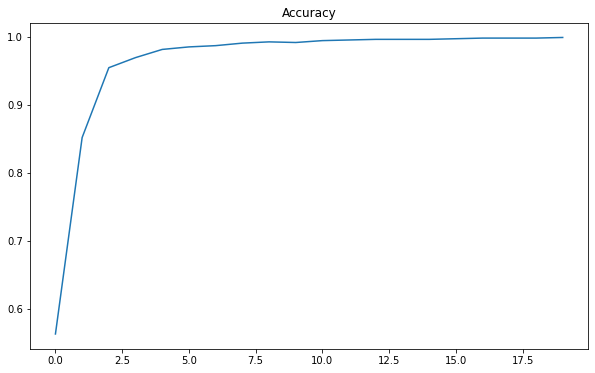

5/5 [==============================] - 0s 4ms/step - loss: 0.1297 - accuracy: 0.9600


[0.12973365187644958, 0.9599999785423279]

In [11]:
import matplotlib.pyplot as plt

model_data=neural_network_model.fit(X_train,
                  Y_train,
                  batch_size=256,           # Batch size
                  epochs=20,                # Epoch frequency
                  verbose=1,                # Enable verbose logging
                  validation_split=0.2)     # Use 20% if training data to validate the model after each epoch

pd.DataFrame(model_data.history)["accuracy"].plot(figsize=(10, 6))
plt.title("Accuracy")
plt.show()
neural_network_model.evaluate(X_test,Y_test)

Save the model for use

In [12]:
neural_network_model.save("spam_prediction")                    # Save model
saved_spam_model = keras.models.load_model("spam_prediction")   # Load model
saved_spam_model.summary()                                      # Print model summary

INFO:tensorflow:Assets written to: spam_prediction\assets
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_hidden_layer (Dense)  (None, 32)                146240    
                                                                 
 second_hidden_layer (Dense)  (None, 32)               1056      
                                                                 
 output_layer (Dense)        (None, 2)                 66        
                                                                 
Total params: 147,362
Trainable params: 147,362
Non-trainable params: 0
_________________________________________________________________


Test the model

In [13]:
# Convert input into IF-IDF vector using the same vectorizer model
predict_tfidf=vectorizer.transform(["FREE entry to a fun contest",
                                    "Yup I will come over"]).toarray()      # Predict for multiple messages at once
print(predict_tfidf.shape)

# Predict using model
prediction=np.argmax( neural_network_model.predict(predict_tfidf), axis=1 )
print("Prediction Output:" , prediction)
print("Prediction Classes are ", label_encoder.inverse_transform(prediction))

(2, 4569)
1/1 [==============================] - 0s 109ms/step
Prediction Output: [1 0]
Prediction Classes are  ['spam' 'ham']
